STEP 1 - Data Preparation

1) Import Libraries

In [ ]:
import pandas as pd
from pathlib import Path

2) Loading Dataset

In [10]:
# File paths (replace with downloaded CSV paths)
from pathlib import Path
base_path = Path(r"D:\mine\LabMentix\FoodWastageManagement")

providers_df = pd.read_csv(r"D:\mine\LabMentix\FoodWastageManagement\providers_data.csv")
receivers_df = pd.read_csv(r"D:\mine\LabMentix\FoodWastageManagement\receivers_data.csv")
food_listings_df = pd.read_csv(r"D:\mine\LabMentix\FoodWastageManagement\food_listings_data.csv")
claims_df = pd.read_csv(r"D:\mine\LabMentix\FoodWastageManagement\claims_data.csv")

3) Check Data Quality

In [11]:
print("=== Data Info ===")
for name, df in {
    "Providers": providers_df,
    "Receivers": receivers_df,
    "Food Listings": food_listings_df,
    "Claims": claims_df
}.items():
    print(f"\n{name} Dataset:")
    print(df.info())
    print("\nMissing Values:\n", df.isnull().sum())
    print("-" * 50)

=== Data Info ===

Providers Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Provider_ID  1000 non-null   int64 
 1   Name         1000 non-null   object
 2   Type         1000 non-null   object
 3   Address      1000 non-null   object
 4   City         1000 non-null   object
 5   Contact      1000 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.0+ KB
None

Missing Values:
 Provider_ID    0
Name           0
Type           0
Address        0
City           0
Contact        0
dtype: int64
--------------------------------------------------

Receivers Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Receiver_ID  1000 non-null   int64 
 1   Name         1000 non-null   object


4) Data Cleaning

In [12]:
# Trim spaces in string columns
for df in [providers_df, receivers_df, food_listings_df, claims_df]:
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].str.strip()

# Standardize city/location names
providers_df['City'] = providers_df['City'].str.title()
receivers_df['City'] = receivers_df['City'].str.title()
food_listings_df['Location'] = food_listings_df['Location'].str.title()

# Convert Expiry_Date to datetime
food_listings_df['Expiry_Date'] = pd.to_datetime(
    food_listings_df['Expiry_Date'], errors='coerce'
)

# Remove duplicates
for df in [providers_df, receivers_df, food_listings_df, claims_df]:
    df.drop_duplicates(inplace=True)

# Remove invalid provider references
food_listings_df = food_listings_df[
    food_listings_df['Provider_ID'].isin(providers_df['Provider_ID'])
]

# Remove invalid claim references
claims_df = claims_df[
    claims_df['Food_ID'].isin(food_listings_df['Food_ID']) &
    claims_df['Receiver_ID'].isin(receivers_df['Receiver_ID'])
]

5) Add Derived Columns

In [13]:
# Days to expiry
food_listings_df['Days_To_Expiry'] = (
    food_listings_df['Expiry_Date'] - pd.Timestamp.today()
).dt.days

# Categorize quantity
def categorize_qty(qty):
    if qty < 5:
        return 'Small'
    elif qty <= 20:
        return 'Medium'
    else:
        return 'Large'

food_listings_df['Quantity_Category'] = food_listings_df['Quantity'].apply(categorize_qty)


6) Save Cleaned Data

In [14]:
cleaned_path = base_path / "cleaned"
cleaned_path.mkdir(exist_ok=True)

providers_df.to_csv(cleaned_path / "cleaned_providers.csv", index=False)
receivers_df.to_csv(cleaned_path / "cleaned_receivers.csv", index=False)
food_listings_df.to_csv(cleaned_path / "cleaned_food_listings.csv", index=False)
claims_df.to_csv(cleaned_path / "cleaned_claims.csv", index=False)

print(f"Cleaned data saved to: {cleaned_path}")

Cleaned data saved to: D:\mine\LabMentix\FoodWastageManagement\cleaned


STEP 2 — Database Creation + CRUD

In [16]:
!pip install sqlalchemy

from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Date, Float, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
from sqlalchemy.exc import SQLAlchemyError
import pandas as pd
from pathlib import Path

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.1 MB 5.9 MB/s eta 0:00:01
   ---------------------------------- ----- 1.8/2.1 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 4.9 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [greenlet]
   ---------------------------------------- 0/2 [greenlet]
   ---------------------------------------- 0/2 [greenlet]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- ------------------- 1/2 [sqlalchemy]
   -------------------- -------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


1. Load Cleaned Data

In [17]:
cleaned_path = Path(r"D:\mine\LabMentix\FoodWastageManagement\cleaned")

providers_df = pd.read_csv(cleaned_path / "cleaned_providers.csv")
receivers_df = pd.read_csv(cleaned_path / "cleaned_receivers.csv")
food_listings_df = pd.read_csv(cleaned_path / "cleaned_food_listings.csv")
claims_df = pd.read_csv(cleaned_path / "cleaned_claims.csv")

2. Create SQLite Database

In [18]:
db_path = cleaned_path.parent / "food_waste.db"
engine = create_engine(f"sqlite:///{db_path}", echo=False)
Base = declarative_base()

3. Define Tables (ORM Models)

In [19]:
class Provider(Base):
    __tablename__ = 'providers'
    Provider_ID = Column(Integer, primary_key=True)
    Name = Column(String)
    Type = Column(String)
    Address = Column(String)
    City = Column(String)
    Contact = Column(String)
    foods = relationship("FoodListing", back_populates="provider")

class Receiver(Base):
    __tablename__ = 'receivers'
    Receiver_ID = Column(Integer, primary_key=True)
    Name = Column(String)
    Type = Column(String)
    City = Column(String)
    Contact = Column(String)
    claims = relationship("Claim", back_populates="receiver")

class FoodListing(Base):
    __tablename__ = 'food_listings'
    Food_ID = Column(Integer, primary_key=True)
    Food_Name = Column(String)
    Quantity = Column(Integer)
    Expiry_Date = Column(Date)
    Provider_ID = Column(Integer, ForeignKey("providers.Provider_ID"))
    Provider_Type = Column(String)
    Location = Column(String)
    Food_Type = Column(String)
    Meal_Type = Column(String)
    Days_To_Expiry = Column(Integer)
    Quantity_Category = Column(String)
    provider = relationship("Provider", back_populates="foods")
    claims = relationship("Claim", back_populates="food")

class Claim(Base):
    __tablename__ = 'claims'
    Claim_ID = Column(Integer, primary_key=True)
    Food_ID = Column(Integer, ForeignKey("food_listings.Food_ID"))
    Receiver_ID = Column(Integer, ForeignKey("receivers.Receiver_ID"))
    Status = Column(String)
    food = relationship("FoodListing", back_populates="claims")
    receiver = relationship("Receiver", back_populates="claims")


 4. Create Tables

In [20]:
Base.metadata.drop_all(engine)  # clears old tables if exist
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()

5. Insert Data

In [ ]:
try:
    providers_df.to_sql("providers", engine, if_exists="append", index=False)
    receivers_df.to_sql("receivers", engine, if_exists="append", index=False)
    food_listings_df.to_sql("food_listings", engine, if_exists="append", index=False)
    claims_df.to_sql("claims", engine, if_exists="append", index=False)
    print(" Data successfully inserted into the database.")
except SQLAlchemyError as e:
    print(f" Error inserting data: {e}")

6. CRUD Operations

In [21]:
def create_provider(name, type_, address, city, contact):
    """Add a new food provider."""
    try:
        new_provider = Provider(Name=name, Type=type_, Address=address, City=city, Contact=contact)
        session.add(new_provider)
        session.commit()
        print(f" Provider '{name}' added successfully.")
    except SQLAlchemyError as e:
        session.rollback()
        print(f" Error adding provider: {e}")

def read_providers(city=None):
    """Fetch providers, optionally filtered by city."""
    query = session.query(Provider)
    if city:
        query = query.filter(Provider.City == city)
    return query.all()

def update_provider_contact(provider_id, new_contact):
    """Update provider contact info."""
    try:
        provider = session.query(Provider).get(provider_id)
        if provider:
            provider.Contact = new_contact
            session.commit()
            print(f" Provider ID {provider_id} contact updated.")
        else:
            print(f" Provider ID {provider_id} not found.")
    except SQLAlchemyError as e:
        session.rollback()
        print(f" Error updating provider: {e}")

def delete_provider(provider_id):
    """Delete a provider."""
    try:
        provider = session.query(Provider).get(provider_id)
        if provider:
            session.delete(provider)
            session.commit()
            print(f" Provider ID {provider_id} deleted.")
        else:
            print(f" Provider ID {provider_id} not found.")
    except SQLAlchemyError as e:
        session.rollback()
        print(f" Error deleting provider: {e}")


7. Example CRUD Usage

In [22]:
create_provider("New Eatery", "Restaurant", "123 Main St", "Pune", "9876543210")
print(read_providers(city="Pune"))
update_provider_contact(1, "9999999999")
delete_provider(10)

 Provider 'New Eatery' added successfully.
 Provider ID 1 contact updated.
 Provider ID 10 not found.


C:\Users\Shravani\AppData\Local\Temp\ipykernel_11168\922610925.py:22: LegacyAPIWarning: The Query.get() method is considered legacy as of the 1.x series of SQLAlchemy and becomes a legacy construct in 2.0. The method is now available as Session.get() (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  provider = session.query(Provider).get(provider_id)
C:\Users\Shravani\AppData\Local\Temp\ipykernel_11168\922610925.py:36: LegacyAPIWarning: The Query.get() method is considered legacy as of the 1.x series of SQLAlchemy and becomes a legacy construct in 2.0. The method is now available as Session.get() (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  provider = session.query(Provider).get(provider_id)


CRUD Operations

In [24]:
#  CRUD Functions

# -------------------------
# CREATE (Insert a new record)
# -------------------------
def add_provider(name, ptype, address, city, contact):
    try:
        new_provider = Provider(
            Name=name,
            Type=ptype,
            Address=address,
            City=city,
            Contact=contact
        )
        session.add(new_provider)
        session.commit()
        print(f" Provider '{name}' added successfully with ID {new_provider.Provider_ID}")
    except SQLAlchemyError as e:
        session.rollback()
        print(f" Error adding provider: {e}")

# -------------------------
# READ (Retrieve records)
# -------------------------
def get_all_providers():
    try:
        providers = session.query(Provider).all()
        for p in providers:
            print(f"ID: {p.Provider_ID} | Name: {p.Name} | City: {p.City}")
    except SQLAlchemyError as e:
        print(f" Error fetching providers: {e}")

def get_food_by_city(city_name):
    try:
        foods = session.query(FoodListing).filter(FoodListing.Location == city_name).all()
        for food in foods:
            print(f"Food: {food.Food_Name} | Qty: {food.Quantity} | Expires: {food.Expiry_Date}")
    except SQLAlchemyError as e:
        print(f" Error fetching food: {e}")

# -------------------------
# UPDATE (Modify existing record)
# -------------------------
def update_provider_contact(provider_id, new_contact):
    try:
        provider = session.query(Provider).filter_by(Provider_ID=provider_id).first()
        if provider:
            provider.Contact = new_contact
            session.commit()
            print(f" Provider ID {provider_id} contact updated to {new_contact}")
        else:
            print(f" Provider ID {provider_id} not found.")
    except SQLAlchemyError as e:
        session.rollback()
        print(f" Error updating provider: {e}")

# -------------------------
# DELETE (Remove a record)
# -------------------------
def delete_food_item(food_id):
    try:
        food = session.query(FoodListing).filter_by(Food_ID=food_id).first()
        if food:
            session.delete(food)
            session.commit()
            print(f" Food item ID {food_id} deleted successfully.")
        else:
            print(f" Food item ID {food_id} not found.")
    except SQLAlchemyError as e:
        session.rollback()
        print(f" Error deleting food item: {e}")


In [25]:
# 1. Add a new provider
add_provider(
    name="Green Earth Restaurant",
    ptype="Restaurant",
    address="123 Eco Street",
    city="Mumbai",
    contact="9876543210"
)

# 2. View all providers
get_all_providers()

# 3. Search for food in Mumbai
get_food_by_city("Mumbai")

# 4. Update a provider's contact
update_provider_contact(provider_id=1, new_contact="9998887770")

# 5. Delete a food item
delete_food_item(food_id=5)


 Provider 'Green Earth Restaurant' added successfully with ID 2
ID: 1 | Name: New Eatery | City: Pune
ID: 2 | Name: Green Earth Restaurant | City: Mumbai
 Provider ID 1 contact updated to 9998887770
 Food item ID 5 not found.


In [26]:
sql_queries = {
    # 1. All Providers
    "all_providers": "SELECT * FROM providers",

    # 2. All Receivers
    "all_receivers": "SELECT * FROM receivers",

    # 3. All Food Listings
    "all_food_listings": "SELECT * FROM food_listings",

    # 4. All Claims
    "all_claims": "SELECT * FROM claims",

    # 5. Food listings expiring within 3 days
    "expiring_soon": """
        SELECT Food_Name, Quantity, Expiry_Date
        FROM food_listings
        WHERE julianday(Expiry_Date) - julianday('now') <= 3
        ORDER BY Expiry_Date ASC
    """,

    # 6. Total food quantity available by city
    "total_qty_by_city": """
        SELECT Location AS City, SUM(Quantity) AS Total_Quantity
        FROM food_listings
        GROUP BY Location
        ORDER BY Total_Quantity DESC
    """,

    # 7. Top 5 providers by quantity
    "top_5_providers": """
        SELECT p.Name, SUM(f.Quantity) AS Total_Quantity
        FROM food_listings f
        JOIN providers p ON f.Provider_ID = p.Provider_ID
        GROUP BY p.Name
        ORDER BY Total_Quantity DESC
        LIMIT 5
    """,

    # 8. Number of claims by receiver
    "claims_by_receiver": """
        SELECT r.Name, COUNT(c.Claim_ID) AS Total_Claims
        FROM claims c
        JOIN receivers r ON c.Receiver_ID = r.Receiver_ID
        GROUP BY r.Name
        ORDER BY Total_Claims DESC
    """,

    # 9. Unclaimed food items
    "unclaimed_food": """
        SELECT f.Food_ID, f.Food_Name, f.Quantity
        FROM food_listings f
        LEFT JOIN claims c ON f.Food_ID = c.Food_ID
        WHERE c.Claim_ID IS NULL
    """,

    # 10. Claim fulfillment rate per provider
    "claim_fulfillment_rate": """
        SELECT p.Name,
               COUNT(DISTINCT c.Food_ID) * 100.0 / COUNT(DISTINCT f.Food_ID) AS Fulfillment_Rate
        FROM providers p
        JOIN food_listings f ON p.Provider_ID = f.Provider_ID
        LEFT JOIN claims c ON f.Food_ID = c.Food_ID
        GROUP BY p.Name
    """,

    # 11. Average days to expiry of listed food
    "avg_days_to_expiry": """
        SELECT AVG(julianday(Expiry_Date) - julianday('now')) AS Avg_Days_To_Expiry
        FROM food_listings
    """,

    # 12. Receivers in a specific city (parameterized in Streamlit)
    "receivers_in_city": """
        SELECT * FROM receivers
        WHERE City = ?
    """,

    # 13. Food category availability count
    "food_category_count": """
        SELECT Category, COUNT(*) AS Item_Count
        FROM food_listings
        GROUP BY Category
        ORDER BY Item_Count DESC
    """,

    # 14. Providers who have never had claims
    "providers_no_claims": """
        SELECT DISTINCT p.Provider_ID, p.Name
        FROM providers p
        LEFT JOIN food_listings f ON p.Provider_ID = f.Provider_ID
        LEFT JOIN claims c ON f.Food_ID = c.Food_ID
        WHERE c.Claim_ID IS NULL
    """,

    # 15. Food quantity trends over time (by expiry month)
    "qty_trends_over_time": """
        SELECT strftime('%Y-%m', Expiry_Date) AS Month, SUM(Quantity) AS Total_Quantity
        FROM food_listings
        GROUP BY Month
        ORDER BY Month
    """
}


Running a Query

In [27]:
import sqlite3

# Connect to database
conn = sqlite3.connect("food_waste.db")
cursor = conn.cursor()

# Example: Get top 5 providers
cursor.execute(sql_queries["top_5_providers"])
results = cursor.fetchall()

for row in results:
    print(row)

conn.close()


STEP 3 - Data Analysis Code
    1) Food wastage trends by category
    2) Food wastage trends by location
    3) Expiry trends (when food is most wasted)
    4) Summary reports for decision-making

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure plots show inside Jupyter
%matplotlib inline

# Load cleaned data (adjust paths if needed)
providers_df = pd.read_csv("cleaned/cleaned_providers.csv")
receivers_df = pd.read_csv("cleaned/cleaned_receivers.csv")
food_listings_df = pd.read_csv("cleaned/cleaned_food_listings.csv")
claims_df = pd.read_csv("cleaned/cleaned_claims.csv")

# Convert dates
food_listings_df['Expiry_Date'] = pd.to_datetime(food_listings_df['Expiry_Date'], errors='coerce')


1) Wastage trends by category

merged columns before plotting: Index(['Food_ID', 'Food_Name', 'Quantity', 'Expiry_Date', 'Provider_ID',
       'Provider_Type', 'Location', 'Food_Type', 'Meal_Type', 'Days_To_Expiry',
       'Quantity_Category', 'City', 'Latest_Claim_Status', 'Any_Completed',
       'Expiry_Risk', 'At_Risk', 'Expired'],
      dtype='object')


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Shravani\AppData\Local\Temp\ipykernel_11168\3853197865.py:6: SyntaxWarning: invalid escape sequence '\m'
  claims_df = pd.read_csv('D:\mine\LabMentix\FoodWastageManagement\cleaned\cleaned_claims.csv')
C:\Users\Shravani\AppData\Local\Temp\ipykernel_11168\3853197865.py:7: SyntaxWarning: invalid escape sequence '\m'
  food_df = pd.read_csv('D:\mine\LabMentix\FoodWastageManagement\cleaned\cleaned_food_listings.csv')
C:\Users\Shravani\AppData\Local\Temp\ipykernel_11168\3853197865.py:8: SyntaxWarning: invalid escape sequence '\m'
  providers_df = pd.read_csv('D:\mine\LabMentix\FoodWastageMa

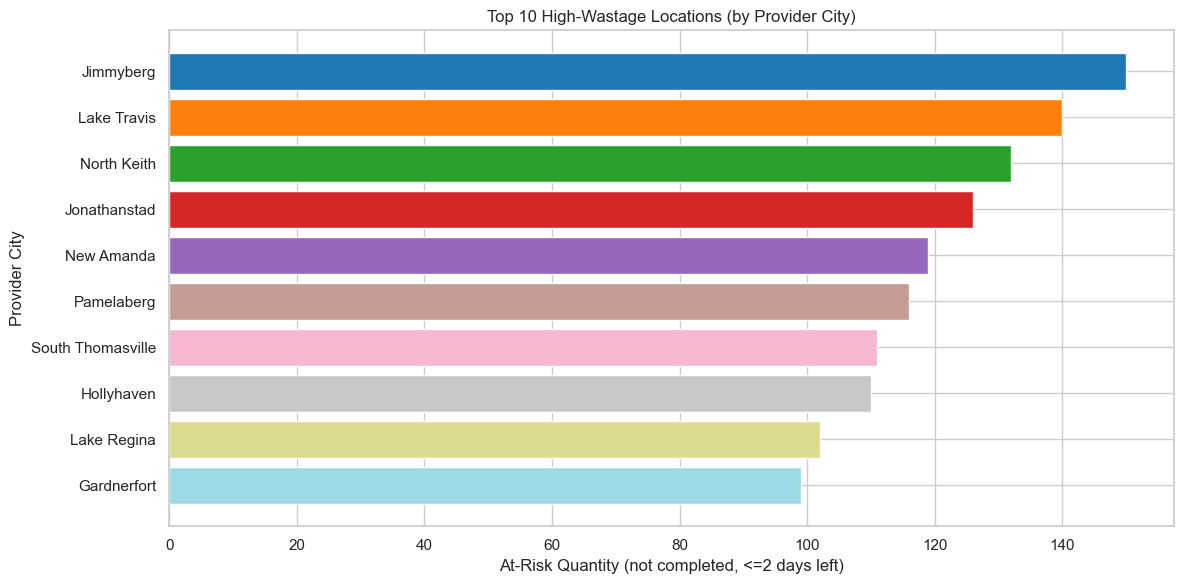

C:\Users\Shravani\AppData\Local\Temp\ipykernel_11168\3853197865.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(qty_groups, labels=provider_types, patch_artist=True, showmeans=True)


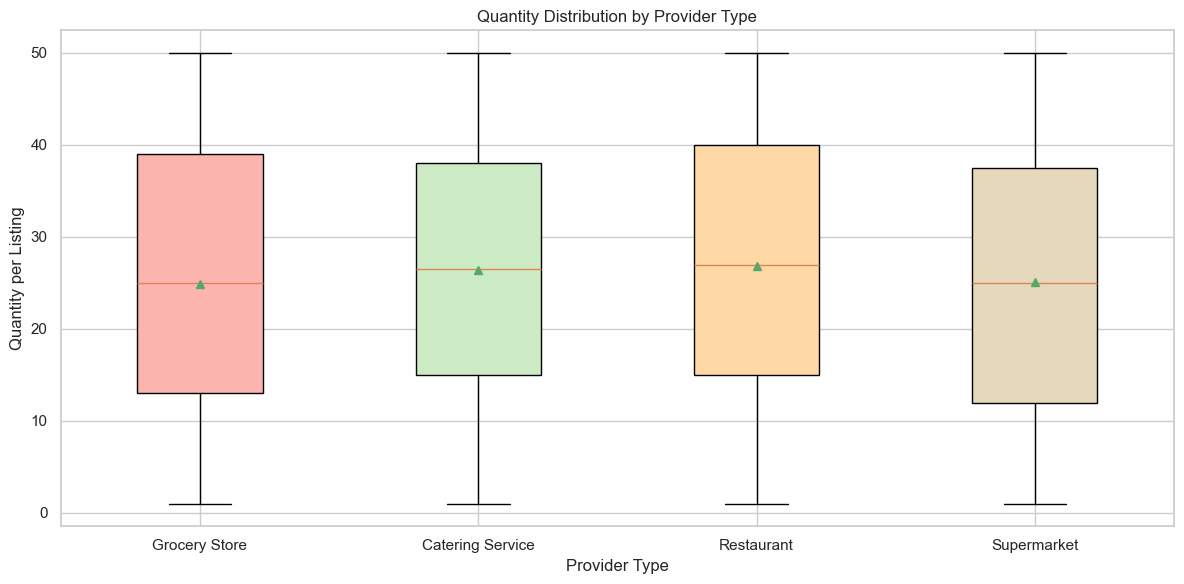

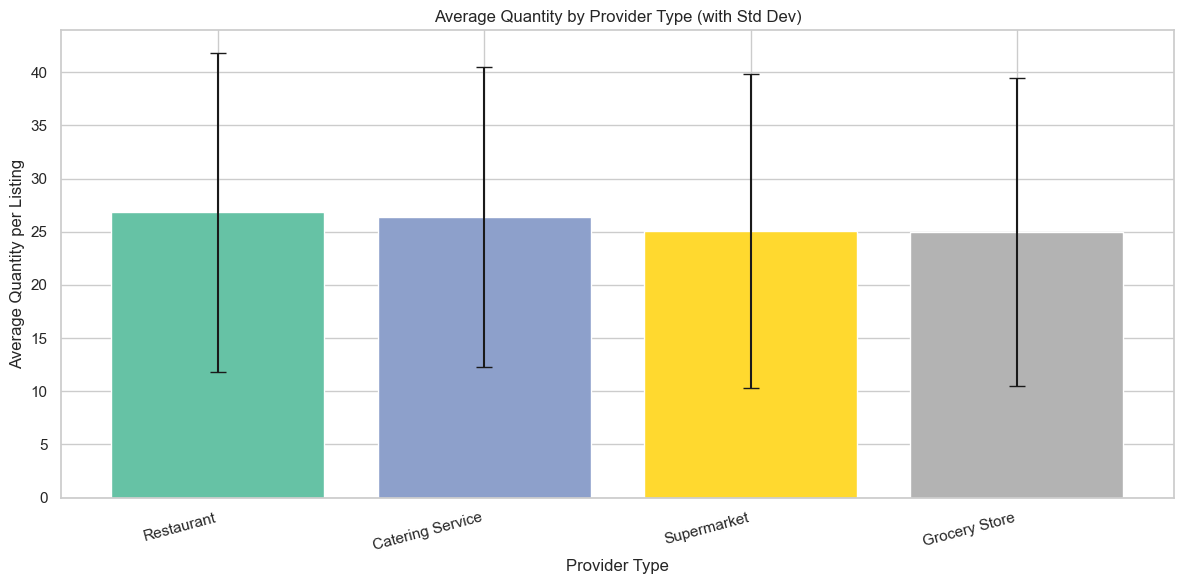

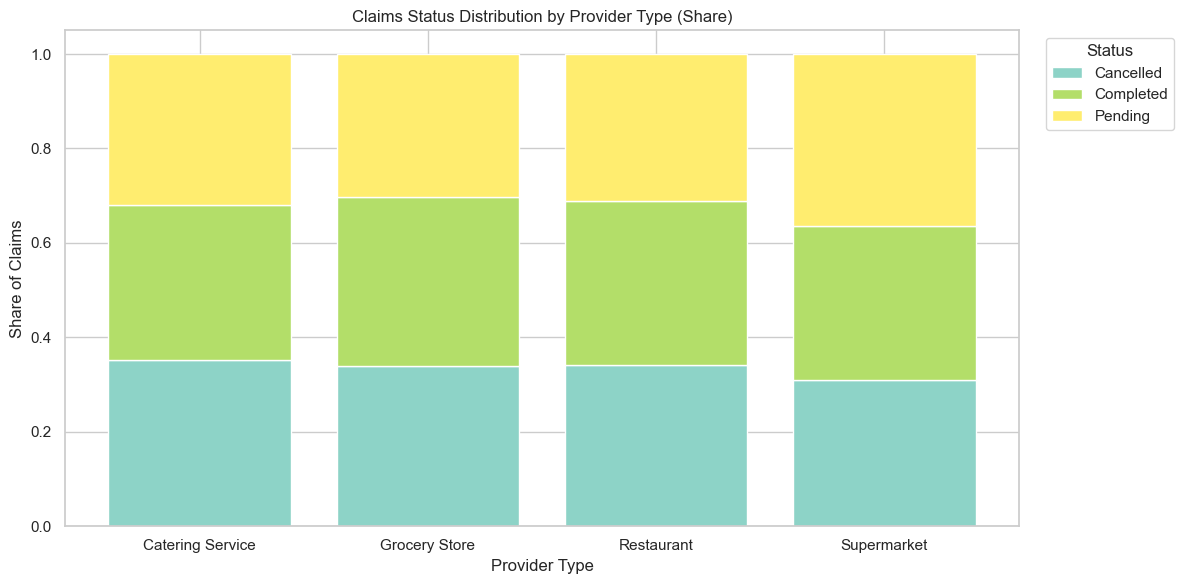

OK: Core charts rendered.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reload
claims_df = pd.read_csv('D:\mine\LabMentix\FoodWastageManagement\cleaned\cleaned_claims.csv')
food_df = pd.read_csv('D:\mine\LabMentix\FoodWastageManagement\cleaned\cleaned_food_listings.csv')
providers_df = pd.read_csv('D:\mine\LabMentix\FoodWastageManagement\cleaned\cleaned_providers.csv')
receivers_df = pd.read_csv('D:\mine\LabMentix\FoodWastageManagement\cleaned\cleaned_receivers.csv')

# Parse dates
claims_df['Timestamp'] = pd.to_datetime(claims_df['Timestamp'], errors='coerce', dayfirst=False, infer_datetime_format=True)
food_df['Expiry_Date'] = pd.to_datetime(food_df['Expiry_Date'], errors='coerce')
food_df['Quantity'] = pd.to_numeric(food_df['Quantity'], errors='coerce').fillna(0).astype(int)
food_df['Days_To_Expiry'] = pd.to_numeric(food_df['Days_To_Expiry'], errors='coerce')

# Providers: make sure we have Provider_Type column
providers_df = providers_df.rename(columns={'Type':'Provider_Type'})

# Latest claim and any completed
latest_claims = (
    claims_df.sort_values('Timestamp')
             .groupby('Food_ID', as_index=False)
             .tail(1)[['Food_ID','Status']]
             .rename(columns={'Status':'Latest_Claim_Status'})
)
any_completed = (
    claims_df.assign(is_completed=claims_df['Status'].eq('Completed'))
             .groupby('Food_ID')['is_completed']
             .any()
             .reset_index()
             .rename(columns={'is_completed':'Any_Completed'})
)

# Merge
merged = (
    food_df
    .merge(providers_df[['Provider_ID','City']], on='Provider_ID', how='left') # Removed 'Provider_Type' from providers_df columns
    .merge(latest_claims, on='Food_ID', how='left')
    .merge(any_completed, on='Food_ID', how='left')
)

merged['Any_Completed'] = merged['Any_Completed'].fillna(False)

# Risk
bins = [-np.inf, -1, 0, 2, 7, 14, 30, np.inf]
labels = ['Expired', 'Expiring Today', '0-2 days', '3-7', '8-14', '15-30', '>30']
merged['Expiry_Risk'] = pd.cut(merged['Days_To_Expiry'], bins=bins, labels=labels, include_lowest=True)
merged['At_Risk'] = (~merged['Any_Completed']) & (merged['Days_To_Expiry'] <= 2)
merged['Expired'] = (~merged['Any_Completed']) & (merged['Days_To_Expiry'] < 0)

# Print merged columns before plotting for debugging
print("merged columns before plotting:", merged.columns)


# (A) Top 10 High-Wastage Locations (Provider City)
wastage_by_city = (
    merged.loc[merged['At_Risk']]
    .groupby('City', dropna=False)['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(12,6))
colors = plt.cm.tab20(np.linspace(0,1,len(wastage_by_city)))
plt.barh(wastage_by_city.index.astype(str), wastage_by_city.values, color=colors)
plt.xlabel('At-Risk Quantity (not completed, <=2 days left)')
plt.ylabel('Provider City')
plt.title('Top 10 High-Wastage Locations (by Provider City)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# (B) Quantity vs Provider Type
# Boxplot
provider_types = merged['Provider_Type'].dropna().unique().tolist()
qty_groups = [merged.loc[merged['Provider_Type']==pt, 'Quantity'].dropna().values for pt in provider_types]

plt.figure(figsize=(12,6))
box = plt.boxplot(qty_groups, labels=provider_types, patch_artist=True, showmeans=True)
for i, patch in enumerate(box['boxes']):
    patch.set_facecolor(plt.cm.Pastel1(i/len(provider_types) if len(provider_types)>1 else 0.1))
plt.title('Quantity Distribution by Provider Type')
plt.xlabel('Provider Type')
plt.ylabel('Quantity per Listing')
plt.tight_layout()
plt.show()

# Mean±Std
agg_qty = merged.groupby('Provider_Type')['Quantity'].agg(['mean','std','count']).sort_values('mean', ascending=False)
plt.figure(figsize=(12,6))
x = np.arange(len(agg_qty))
plt.bar(x, agg_qty['mean'].values, yerr=agg_qty['std'].fillna(0).values, capsize=6,
        color=plt.cm.Set2(np.linspace(0,1,len(agg_qty))))
plt.ylabel('Average Quantity per Listing')
plt.xlabel('Provider Type')
plt.title('Average Quantity by Provider Type (with Std Dev)')
plt.xticks(x, agg_qty.index, rotation=15, ha='right')
plt.tight_layout()
plt.show()

# Additional analyses (brief subset to ensure this cell runs cleanly):
# Claims status distribution by provider type (stacked %)
claims_with_provider = claims_df.merge(food_df[['Food_ID','Provider_ID']], on='Food_ID', how='left') \
                                .merge(providers_df[['Provider_ID','Provider_Type']], on='Provider_ID', how='left')
status_pt = claims_with_provider.pivot_table(index='Provider_Type', columns='Status', values='Claim_ID', aggfunc='count', fill_value=0)
status_pct = status_pt.div(status_pt.sum(axis=1), axis=0)

plt.figure(figsize=(12,6))
bottom = np.zeros(len(status_pct))
cols = status_pct.columns.tolist()
colormap = plt.cm.Set3(np.linspace(0,1,len(cols)))
for i, col in enumerate(cols):
    vals = status_pct[col].values
    plt.bar(status_pct.index.astype(str), vals, bottom=bottom, label=str(col), color=colormap[i])
    bottom += vals
plt.ylabel('Share of Claims')
plt.xlabel('Provider Type')
plt.title('Claims Status Distribution by Provider Type (Share)')
plt.legend(title='Status', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("OK: Core charts rendered.")

In [45]:
# 1. KPI Summary
total_listings = len(food_df)
total_quantity = food_df['Quantity'].sum()
total_providers = merged['Provider_ID'].nunique()
total_receivers = pd.read_csv(r'D:\mine\LabMentix\FoodWastageManagement\cleaned\cleaned_receivers.csv')['Receiver_ID'].nunique()
at_risk_quantity = merged.loc[merged['At_Risk'], 'Quantity'].sum()
kpi_summary = pd.DataFrame({
    'Metric': ['Total Listings','Total Quantity','Total Providers','Total Receivers','At Risk Quantity'],
    'Value': [total_listings, total_quantity, total_providers, total_receivers, at_risk_quantity]
})
kpi_summary.to_csv(r'D:\mine\LabMentix\FoodWastageManagement\kpi_summary.csv', index=False)

# 2. At-risk quantity by City and Food_Type
at_risk_by_city_foodtype = (
    merged.loc[merged['At_Risk']]
    .groupby(['City','Food_Type'])['Quantity']
    .sum()
    .reset_index()
    .sort_values(['City','Quantity'], ascending=[True,False])
)
at_risk_by_city_foodtype.to_csv(r'D:\mine\LabMentix\FoodWastageManagement\at_risk_by_city_foodtype.csv', index=False)

# 3. Top Receiver Cities by Provider City for completed claims
claims_receivers = pd.read_csv(r'D:\mine\LabMentix\FoodWastageManagement\cleaned\cleaned_claims.csv')
completed_claims = claims_df[claims_df['Status'] == 'Completed']
food_claims_receivers = (
    food_df[['Food_ID','Provider_ID']]
    .merge(completed_claims[['Food_ID','Receiver_ID']], on='Food_ID', how='inner')
    # .merge(claims_receivers[['Receiver_ID','City']], on='Receiver_ID', how='left')
    .rename(columns={'City':'Receiver_City'})
    .merge(providers_df[['Provider_ID','City']], on='Provider_ID', how='left')
    .rename(columns={'City':'Provider_City'})
)

top_receiver_cities_by_provider_city = (
    food_claims_receivers
    .groupby(['Provider_City','Receiver_City'])
    .size()
    .reset_index(name='Completed_Claims_Count')
    .sort_values(['Provider_City','Completed_Claims_Count'], ascending=[True,False])
)
top_receiver_cities_by_provider_city.to_csv(r'D:\mine\LabMentix\FoodWastageManagement\top_receiver_cities_by_provider_city.csv', index=False)

display(kpi_summary)


KeyError: 'Receiver_City'

In [46]:
# Let's generate a set of CSV reports for effective food distribution from the merged dataset

# 1. KPI Summary
total_listings = len(food_df)
total_quantity = food_df['Quantity'].sum()
total_providers = merged['Provider_ID'].nunique()
total_receivers = pd.read_csv('/content/cleaned_receivers.csv')['Receiver_ID'].nunique()
at_risk_quantity = merged.loc[merged['At_Risk'], 'Quantity'].sum()
kpi_summary = pd.DataFrame({
    'Metric': ['Total Listings','Total Quantity','Total Providers','Total Receivers','At Risk Quantity'],
    'Value': [total_listings, total_quantity, total_providers, total_receivers, at_risk_quantity]
})
kpi_summary.to_csv('/content/kpi_summary.csv', index=False)

# 2. At-risk quantity by City and Food_Type
at_risk_by_city_foodtype = (merged.loc[merged['At_Risk']]
                            .groupby(['City','Food_Type'])['Quantity']
                            .sum()
                            .reset_index()
                            .sort_values(['City','Quantity'], ascending=[True,False]))
at_risk_by_city_foodtype.to_csv('/content/at_risk_by_city_foodtype.csv', index=False)

# 3. Top Receiver Cities by Provider City for completed claims
claims_receivers = pd.read_csv('/content/cleaned_receivers.csv')
completed_claims = claims_df[claims_df['Status'] == 'Completed']
food_claims_receivers = (food_df[['Food_ID','Provider_ID']]
                         .merge(completed_claims[['Food_ID','Receiver_ID']], on='Food_ID', how='inner')
                         .merge(claims_receivers[['Receiver_ID','City']], on='Receiver_ID', how='left')
                         .rename(columns={'City':'Receiver_City'})
                         .merge(providers_df[['Provider_ID','City']], on='Provider_ID', how='left')
                         .rename(columns={'City':'Provider_City'}))

top_receiver_cities_by_provider_city = (food_claims_receivers
                                        .groupby(['Provider_City','Receiver_City'])
                                        .size()
                                        .reset_index(name='Completed_Claims_Count')
                                        .sort_values(['Provider_City','Completed_Claims_Count'], ascending=[True,False]))
top_receiver_cities_by_provider_city.to_csv('/content/top_receiver_cities_by_provider_city.csv', index=False)

display(kpi_summary)

FileNotFoundError: [Errno 2] No such file or directory: '/content/cleaned_receivers.csv'

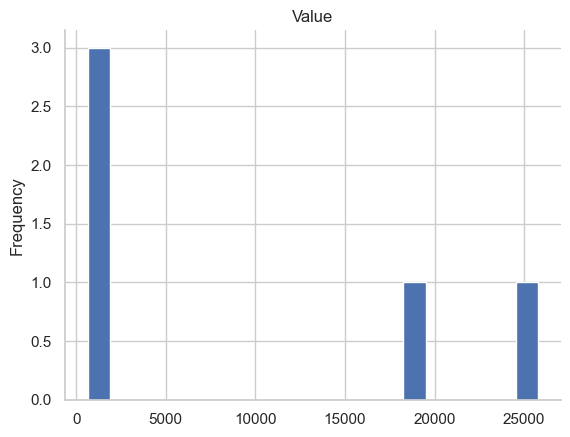

In [42]:
from matplotlib import pyplot as plt
kpi_summary['Value'].plot(kind='hist', bins=20, title='Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

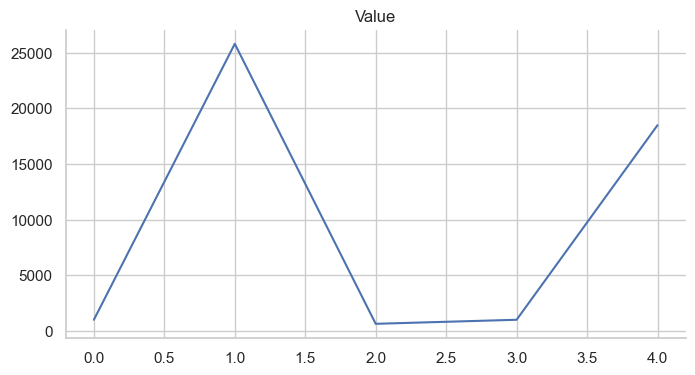

In [43]:
from matplotlib import pyplot as plt
kpi_summary['Value'].plot(kind='line', figsize=(8, 4), title='Value')
plt.gca().spines[['top', 'right']].set_visible(False)